In [6]:
import sys
sys.path.append("../") 

In [7]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='../data',cache=True,as_frame=False)
X=X/255.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [9]:
import numpy as np
from hamiltonian import utils

num_examples,num_inputs=X_train.shape
num_outputs=len(np.unique(y_train))

#y_train=utils.one_hot(y_train,num_outputs)
#y_test=utils.one_hot(y_test,num_outputs)

In [10]:
y_train=np.int32(y_train)
y_test=np.int32(y_test)

### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [29]:
import mxnet as mx
from mxnet import nd, autograd, gluon
model_ctx=mx.cpu()
hyper={'alpha':10.}
in_units=X_train.shape[1]
out_units=len(np.unique(y_train))

In [63]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import mlp_softmax

model=mlp_softmax(hyper,in_units,out_units,4,32,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.001,ctx=model_ctx)

In [64]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgd)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


no modules loaded yet


In [65]:
par,loss=inference.fit(epochs=10,batch_size=64,X_train=X_train,y_train=y_train,verbose=False)

100%|██████████| 10/10 [00:57<00:00,  5.79s/it]


In [18]:
model.net.collect_params()

{'0.weight': Parameter (shape=(64, 784), dtype=float32),
 '0.bias': Parameter (shape=(64,), dtype=float32),
 '1.weight': Parameter (shape=(64, 64), dtype=float32),
 '1.bias': Parameter (shape=(64,), dtype=float32),
 '2.weight': Parameter (shape=(64, 64), dtype=float32),
 '2.bias': Parameter (shape=(64,), dtype=float32),
 '3.weight': Parameter (shape=(64, 64), dtype=float32),
 '3.bias': Parameter (shape=(64,), dtype=float32),
 '4.weight': Parameter (shape=(10, 64), dtype=float32),
 '4.bias': Parameter (shape=(10,), dtype=float32)}

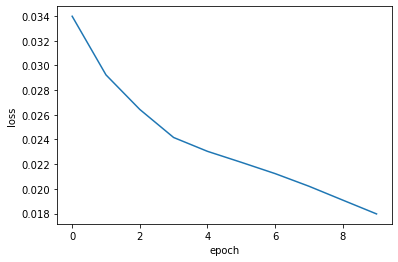

In [26]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [27]:
y_pred=model.predict(model.par,nd.array(X_test,ctx=model_ctx))

In [43]:
from mxnet.gluon.model_zoo.vision import resnet 

resnet=resnet.get_resnet(2,18,pretrained=True)
#resnet=#get_resnet(version, num_layers, pretrained=False, ctx=cpu(),
               

In [28]:
samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())

In [29]:
samples=np.asarray(samples)

In [30]:
y_hat=np.quantile(samples,.5,axis=0)

In [31]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1432
           1       0.94      0.90      0.92      1561
           2       0.75      0.49      0.59      1397
           3       0.57      0.70      0.63      1447
           4       0.87      0.81      0.84      1352
           5       0.53      0.67      0.59      1287
           6       0.82      0.87      0.84      1378
           7       0.75      0.87      0.80      1420
           8       0.53      0.50      0.51      1376
           9       0.78      0.76      0.77      1350

    accuracy                           0.74     14000
   macro avg       0.75      0.74      0.74     14000
weighted avg       0.75      0.74      0.74     14000



In [45]:
X_batch=nd.array(X_train[:32],ctx=model_ctx)
y_batch=nd.array(y_train[:32],ctx=model_ctx)

In [49]:
like=model.negative_log_likelihood(model.par,X_train=X_batch,y_train=y_batch)
prior=model.negative_log_prior(model.par)

In [51]:
prior


[20.794588]
<NDArray 1 @gpu(0)>

# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [53]:
import mxnet as mx
from mxnet import nd, autograd, gluon, init
model_ctx=mx.gpu()
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),
     'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}

In [54]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import softmax

model=mlp_softmax(hyper,in_units,out_units,4,32,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.005,ctx=model_ctx)

In [55]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgld)

<module 'hamiltonian.inference.sgld' from '../hamiltonian/inference/sgld.py'>

In [56]:
par,loss,posterior_samples=inference.fit(epochs=100,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=False)

100%|██████████| 100/100 [37:18<00:00, 22.38s/it]


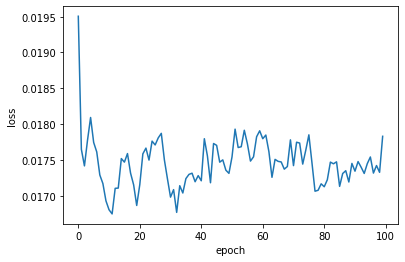

In [57]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [58]:
from sklearn.metrics import classification_report

samples=[]
for i in range(30):
    par={name:posterior_samples[name][i] for name in posterior_samples.keys()}
    y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)
y_hat=np.quantile(samples,.5,axis=0)

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.98      0.70      0.82      1425
           1       0.98      0.86      0.91      1564
           2       0.85      0.75      0.80      1438
           3       0.82      0.72      0.76      1442
           4       0.69      0.87      0.77      1366
           5       0.42      0.82      0.56      1244
           6       0.68      0.71      0.69      1363
           7       0.84      0.89      0.86      1429
           8       0.77      0.60      0.67      1342
           9       0.89      0.62      0.73      1387

    accuracy                           0.75     14000
   macro avg       0.79      0.75      0.76     14000
weighted avg       0.80      0.75      0.76     14000



In [59]:
samples=[]
for i in range(30):
    par={name:posterior_samples[name][i] for name in posterior_samples.keys()}
    y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))
    samples.append(y_pred.log_prob(nd.array(y_test,ctx=model_ctx)))
samples=np.asarray(samples)


# Bayes by Backprop <a class="anchor" id="chapter3"></a>

In [68]:
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),
     'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}

In [69]:
from hamiltonian.inference.bbb import bbb
from hamiltonian.models.softmax import softmax

model=mlp_softmax(hyper,in_units,out_units,4,32,ctx=model_ctx)
inference=bbb(model,model.par,step_size=0.05,ctx=model_ctx)

In [70]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.bbb)

<module 'hamiltonian.inference.bbb' from '../hamiltonian/inference/bbb.py'>

In [71]:
par,loss,(means,sigmas)=inference.fit(epochs=10,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=False)

100%|██████████| 10/10 [07:41<00:00, 46.12s/it]


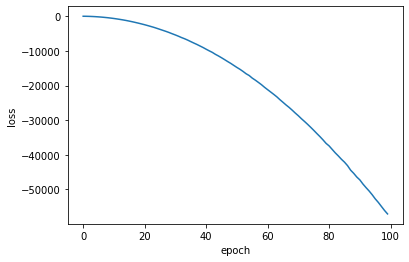

In [66]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [67]:
from sklearn.metrics import classification_report
import mxnet.gluon.probability as mxp

def softplus(x):
    return nd.log(1. + nd.exp(x))

posterior=dict()
for var in par.keys():
    variational_posterior=mxp.normal.Normal(loc=means[var],
                                            scale=softplus(sigmas[var]))
    posterior.update({var:variational_posterior})
    
samples=[]
for _ in range(100):
    post_par=dict()
    for var in par.keys():
        post_par.update({var:posterior[var].sample().as_nd_ndarray()})
    y_pred=model.predict(post_par,nd.array(X_test,ctx=model_ctx))
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)
y_hat=np.quantile(samples,.5,axis=0)

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1425
           1       0.00      0.00      0.00      1564
           2       0.00      0.00      0.00      1438
           3       0.00      0.00      0.00      1442
           4       0.00      0.00      0.00      1366
           5       0.00      0.00      0.00      1244
           6       0.10      0.83      0.18      1363
           7       0.21      0.35      0.26      1429
           8       0.04      0.01      0.01      1342
           9       0.00      0.00      0.00      1387

    accuracy                           0.12     14000
   macro avg       0.03      0.12      0.05     14000
weighted avg       0.03      0.12      0.05     14000



# Posterior Diagnostics <a class="anchor" id="chapter4"></a>

In [36]:
import arviz as az

In [39]:
np.expand_dims(np.asarray([posterior_samples['0.bias'][0].asnumpy() for sample in posterior_samples['0.bias']]),0).shape

(1, 30, 10)

In [40]:
posterior_samples_numpy=dict()

for var in posterior_samples.keys():
    posterior_samples_numpy.update(
        {var:np.expand_dims(np.asarray(
            [sample.asnumpy() for sample in posterior_samples[var]]),0)
        })


In [58]:
posterior_samples_numpy['0-weights'].shape

(1, 5, 784, 10)

In [59]:
dataset = az.convert_to_inference_data(posterior_samples_numpy)

In [60]:
ess=az.ess(dataset)

In [61]:
ess

<xarray.Dataset>
Dimensions:        (bias_dim_0: 10, weights_dim_0: 784, weights_dim_1: 10)
Coordinates:
  * weights_dim_0  (weights_dim_0) int64 0 1 2 3 4 5 ... 778 779 780 781 782 783
  * weights_dim_1  (weights_dim_1) int64 0 1 2 3 4 5 6 7 8 9
  * bias_dim_0     (bias_dim_0) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    weights        (weights_dim_0, weights_dim_1) float64 4.0 4.0 ... 4.0 4.0
    bias           (bias_dim_0) float64 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0

In [62]:
az.summary(dataset)

arviz - WARNING - Shape validation failed: input_shape: (1, 5), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"weights[0,0]",1.862,0.0,1.862,1.862,0.0,0.0,4.0,4.0,NaN
"weights[0,1]",-2.258,0.0,-2.258,-2.258,0.0,0.0,4.0,4.0,NaN
"weights[0,2]",-1.389,0.0,-1.389,-1.389,0.0,0.0,4.0,4.0,NaN
"weights[0,3]",-1.668,0.0,-1.668,-1.668,0.0,0.0,4.0,4.0,NaN
"weights[0,4]",-1.602,0.0,-1.602,-1.602,0.0,0.0,4.0,4.0,NaN
...,...,...,...,...,...,...,...,...,...
bias[5],0.509,0.0,0.509,0.509,0.0,0.0,4.0,4.0,NaN
bias[6],-0.058,0.0,-0.058,-0.058,0.0,0.0,4.0,4.0,NaN
bias[7],0.362,0.0,0.362,0.362,0.0,0.0,4.0,4.0,NaN
bias[8],-0.409,0.0,-0.409,-0.409,0.0,0.0,4.0,4.0,NaN


In [63]:
784*10+10

7850